### AI Research Agent prototype

Features:
1. User enters query/ topic of research
2. The agent plans the flow, research -> reflect on findings -> summarize findings
3. User gets a summary with citations of papers used

In [10]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict


# we need states for:
# user query
# results
class AgentState(TypedDict):
    query: str # the user query
    original_plan: Dict[str, str] # entire plan returned by the planner, with rationale and reflection
    plan: List[Dict] # 
    results: Dict
    reflection: bool
    reflection_notes: str
    summary: str

Now that we have defined the state, we create our nodes.
First node is the planner node. We also need an llm to generate the execution plan, so first we define our llm

In [ ]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage

load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [ ]:
# Test the planner prompt
system_prompt = """ 
You are an expert research agent. 
You have access to an arxiv search and a web search tool. 
Given a user query, create an execution plan mapping the steps needed to get the desired result for the user.
The plan should be detailed, with each step of the plan having the following:
    1. Purpose: why is this step included in the execution plan
    2. Query parameters: Only for the search tools
    - search terms: exact terms to search for in the arxiv search_query or web search
    - additional focus: any keywords that might help us to refine the search
    3. Rationale: The rationale behind these search/ plan parameters. 
The plan should additionally follow a self reflection step, 
where it goes over the output generated from the search results
to determine whether the data that we have is enough or more information is needed to make an informed decision
The self reflection step should also be detailed with the following:
    1. Purpose
    2. Analysis focus
    3. Rationale
Limit your response to 500 words

User query: 
"""

response = llm.invoke(system_prompt + " write a report on evolution of LLMs")
print(response.content)

**Execution Plan**

**Step 1: Foundational Models and Transformer Architecture**

1.  **Purpose**: To identify the key foundational architectures preceding LLMs and the introduction of the Transformer architecture, which revolutionized the field.
2.  **Query Parameters**:
    *   **Search Tool**: arxiv
    *   **Search Terms**: "Transformer architecture", "Attention Is All You Need", "RNN LSTM natural language processing"
    *   **Additional Focus**: neural networks, sequence-to-sequence, machine translation
3.  **Rationale**: "Attention Is All You Need" is the seminal paper for Transformers. Searching for earlier architectures like RNNs and LSTMs will provide context on what Transformers replaced or improved upon. arXiv is ideal for foundational research papers.

**Step 2: Early LLMs and Scaling**

1.  **Purpose**: To identify the first significant LLMs built upon the Transformer architecture and understand the initial phases of scaling and their capabilities.
2.  **Query Parameters*

In [ ]:
system_prompt = """
You are an expert research agent planner.

You have access to the following tools:
- arxiv_search: for academic papers
- web_search: for general sources

Your job is to take a user query and return a structured execution plan in STRICT JSON format.
Do not include any text outside of the JSON. Do not explain your reasoning in prose.

The JSON must follow this schema exactly:

{
  "plan": [
    {
      "tool": "<tool_name>",
      "purpose": "<why this step is included>",
      "query": {
        "search_terms": ["<list of exact search terms>"],
        "additional_focus": ["<list of optional focus keywords>"]
      },
      "rationale": "<why these parameters were chosen>"
    }
  ],
  "reflection": {
    "purpose": "<why reflection is needed>",
    "analysis_focus": ["<list of aspects to check>"],
    "rationale": "<why this reflection matters>"
  }
}

Return only valid JSON. Do not include markdown formatting, explanations, or extra text.
"""

response = llm.invoke(system_prompt + "\nUser query: comparison of different image generation models")
print(response.content, type(response.content))

{
  "plan": [
    {
      "tool": "arxiv_search",
      "purpose": "To find broad survey papers or comprehensive reviews that compare various image generation models at a high level, providing an initial overview.",
      "query": {
        "search_terms": ["image generation models comparison", "generative models survey"],
        "additional_focus": ["review", "benchmark", "evaluation", "performance"]
      },
      "rationale": "These search terms are chosen to directly target papers that perform a comparative analysis across different types of image generation models, such as GANs, VAEs, and Diffusion Models. 'Survey', 'benchmark', 'evaluation', and 'performance' are added to narrow down to papers specifically focused on comparison and assessment."
    },
    {
      "tool": "arxiv_search",
      "purpose": "To find comparisons specifically focused on Generative Adversarial Networks (GANs) and their variants, as they were a dominant paradigm for a significant period.",
      "query"

Now that we have a sample prompt and response to generate a plan, let's add that to a planner node.

* The planner node will have a system prompt and a user query from the state. 
* The LLM returns a structured JSON object with the detailed execution plan.
* We parse that JSON and update the state variables accordingly.

In [12]:
import json

def planner(state: AgentState) -> AgentState:
    """ Generate a detailed execution plan for the user query """

    # First check if there are any previous reflections in reflection_notes
    # If yes, generate a new plan/ or additional search parameters
    # If no, this is the first run, run normally
    # So we probably also need to manage the original_plan somehow to accomodate the new plan after reflection, if any
    
    system_prompt = """
    You are an expert research agent planner.

    You have access to the following tools:
    - arxiv_search: for academic papers

    Your job is to take a user query and return a structured execution plan in STRICT JSON format.
    Do not include any text outside of the JSON. Do not explain your reasoning in prose.

    The JSON must follow this schema exactly:

    {
    "plan": [
        {
        "tool": "<tool_name>",
        "purpose": "<why this step is included>",
        "query": {
            "search_terms": ["<list of exact search terms>"],
            "additional_focus": ["<list of optional focus keywords>"]
        },
        "rationale": "<why these parameters were chosen>"
        }
    ],
    "reflection": {
        "purpose": "<why reflection is needed>",
        "analysis_focus": ["<list of aspects to check>"],
        "rationale": "<why this reflection matters>"
    }
    }

    Return  ONLY VALID JSON. Do not include markdown formatting (NO ```json ... ```), explanations, or extra text.
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["query"])
    ]

    # response = llm.invoke(system_prompt + state["query"])

    response = llm.invoke(messages)
    response_json = response.content[7:-3]
    try:
        state["original_plan"] = json.loads(response_json) # Load plan JSON as python dictionary
    except Exception as e:
        print(response)
        print(e)
    
    response_dict = json.loads(response_json) # Convert JSON string to python dictionary

    state["plan"] = response_dict["plan"]

    return state


The planner node is ready now, let's start defining our tools. Currently we have two tools:

1. arxiv search
2. websearch (probably serpapi)

Just defining the tool skeleton for now

In [ ]:
from langchain_core.tools import tool
import feedparser
from langgraph.prebuilt import ToolNode
from urllib.parse import quote

@tool
def search_arxiv(state: AgentState) -> list[dict[str:any]]:
    """ given the current Agent State, search arxiv and return appropriate papers. """
    
    # pass the search_terms and additional_terms to the llm
    search_terms = state["plan"][0]["query"]["search_terms"]
    additional_focus = state["plan"][0]["query"]["additional_terms"]

    # make the llm generate appropriate arxiv search queries

    query_expansion_prompt = f"""
    You are an expert at constructing arxiv API queries. 
    Given the following search terms and additional focus terms, generate efficient arXiv API queries.

    Requirements:
    - Always include the exact search_terms verbatim.
    - Incorporate additional_focus terms.
    - Use arXiv field prefixes where appropriate:
      - ti: for title
      - abs: for abstract
      - cat:cs.CL for computational linguistics
    - Combine terms with AND/OR for precision.
    - Return 2-3 queries max.

    Return only a JSON list of objects. 
    Each object must have:
    - "search_query": a valid arXiv API query string
    - "max_results": an integer (default 5)

    Return only valid JSON. Do not include markdown formatting, explanations, or extra text.
    """

    messages = [
       SystemMessage(content=query_expansion_prompt), 
       HumanMessage(content=f"\nSearch terms:{search_terms}\nAdditional focus:{additional_focus}")
    ]

    # queries = llm.invoke(query_expansion_prompt)

    queries = llm.invoke(messages)
    queries_json = queries.content[7:-3]

    try:
      queries_dict = json.loads(queries_json)
    except Exception as e:
      print(queries)
      print(e)
    
    # use those queries to search the web for top results

    base_url = 'http://export.arxiv.org/api/query?'
    results = []
    max_results = 5

    # construct valid arxiv url for each search query returned by the LLM and get appropriate papers
    for query in queries_dict:
        search_query = quote(query["search_query"])  # URL-encode
        url = base_url + f"search_query={search_query}&max_results={max_results}&sortBy=submittedDate&sortOrder=descending"
        # print(url)
        feed = feedparser.parse(url)
        results.append(feed.entries)

    # consolidate all results somehow (not thought about it yet)
    # for now, just as a list
    # will use a vector store later

    for i in range(len(results)):
      for result in results[i]:
          # print(result)
          # print("Title:", result.title)
          # print("Authors:", [author['name'] for author in result['authors']])
          # print("Published:", result['published'])
          # print("Summary:", result['summary'])
          # print("Link:", result['link'])
          # print("\n")

          result_dict = {
            "title": result['title'],
            "published:": result['published'],
            "summary:": result['summary'],
            "arxiv_link:": result['link'],
            "pdf_link": result['links'][2]['href'] # or just /pdf instead of /obs in the arxiv link
          }

          state["results"]["arxiv"].append((result_dict))

    # finally, pop the current tool from plan (pop(0))
    state["plan"].pop(0)
    
    return state["results"]["arxiv"]


# Skipping web search for the initial MVP, will add later once the entire flow is working with arxiv
@tool
def search_web(search_terms: list[str], additional_focus: list[str]) -> list[dict[str:str]]:
    """ given some search terms and additional focus terms,
      search the web and retrieve results """
    
    # pass the search_terms and additional_terms to the llm
    # make the llm generate appropriate web search queries
    # use those queries to search arxiv for top papers
    # consolidate all papers somehow (not thought about it yet)
    # finally, pop the current tool from plan (pop(0))
    
    return [{"title":"...", "author":"...", "abstract":"..."}]


tools = [search_arxiv]
tool_node = ToolNode(tools=tools)

Now, we have defined our tools. Let's add the router node that will check if any tools are yet to be called and routes actions accordingly

In [ ]:


def router(state: AgentState):
    """ To check if any more tool calls are left and routing to the appropriate tools """

    # if plan is empty, go to the reflection step
    if not state["plan"]:
        return "reflection"
    else:
        return ToolInvocation(
            tool=state["plan"][0]["tool"],
            tool_input=state
        )


Add a reflection node and a summarize node

In [15]:
def reflection(state: AgentState):
    """ reflect on the current findings """

    # This will again be a conditional edge, which will either route to summarize or back to plan
    # Implement reflection/ EVAL logic
    # If reflection sufficient, route to the summarize state
    # Else, store reflection_notes, go back to the planner with current reflection, generate and execute new plan

    original_reflection = json.dumps(state["original_plan"]["reflection"])
    papers_json = json.dumps(state["results"]["arxiv"])

    system_prompt = """
    You are a research agent tasked with evaluating whether the collected papers are sufficient to fulfill the current research plan.

    Instructions:
    - Read the research plan's reflection goal carefully.
    - Review the list of retrieved papers (title, summary, link).
    - Decide whether these papers are sufficient to proceed to summarization.
    - If sufficient, explain why.
    - If not, explain what is missing and suggest new directions to search.

    Return only valid JSON in the following format:
    {
    "sufficient": true or false,
    "notes": "Your reasoning and suggestions"
    }
    Return only valid JSON. Do not include markdown formatting, explanations, or extra text.
    """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="\nplanned reflection:\n" + original_reflection + "\nCollecte papers in JSON format:\n"+papers_json)
    ]

    # response = llm.invoke(system_prompt + "\nplanned reflection:\n" + original_reflection + "\nCollecte papers in JSON format:\n"+papers_json)
    response = llm.invoke(messages)
    response_json = response.content[7:-3]

    try:
        response_dict = json.loads(response_json)
    except Exception as e:
        print(response)
        print(e)

    state["reflection"] = response_dict["sufficient"]
    state["reflection_notes"] = response_dict["notes"]

    if state["reflection"]:
        return "summarize"
    else:
        return "plan"

def summarize(state: AgentState) -> AgentState:
    """ summarize the findings """

    # Summarize the findings and store them in the state["summary"]

    papers = json.dumps(state["results"]["arxiv"])

    prompt = f"""
    You are a research agent tasked with summarizing the findings from a set of retrieved papers.

    Instructions:
    - Read the titles, summaries, and links of the papers.
    - Synthesize the key insights relevant to the original research goal.
    - Reference paper titles and include links where appropriate.
    - Write a coherent, readable summary suitable for a research report.
    """

    # User Query:
    # {state["query"]}

    # Papers:
    # {papers}

    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content=f"User query: {state["query"]}\nPapers: {papers}")
    ]

    summary = llm.invoke(messages)
    state["final_summary"] = summary


    return state

Now, create the graph. This is still just a skeleton graph to inspect the structure

In [16]:
graph = StateGraph(AgentState)

graph.add_node("planner", planner)
graph.add_node("router", lambda state:state)
graph.add_edge("planner", "router")
graph.add_node("reflection", lambda state:state)
graph.add_node("summarize", summarize)
graph.add_node("tools", tool_node)
graph.set_entry_point("planner")

graph.add_conditional_edges(
    "router",
    router,
    {
        "use_tool": "tools",
        "reflection": "reflection"
    }
)
graph.add_edge("tools", "router")

graph.add_conditional_edges(
    "reflection",
    reflection,
    {
        "summarize":"summarize",
        "plan": "planner"
    }
)

graph.add_edge("summarize", END)

app = graph.compile()

Visualize the graph

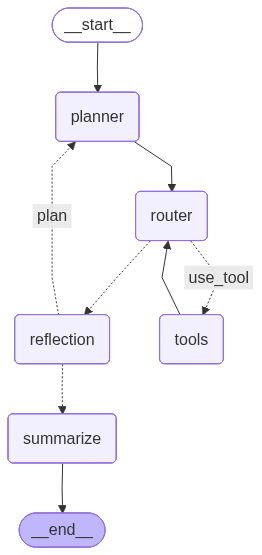

In [17]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
# class AgentState(TypedDict):
#     query: str # the user query
#     original_plan: Dict[str, str] # entire plan returned by the planner, with rationale and reflection
#     plan: List[Dict] # 
#     results: Dict
#     reflection: bool
#     reflection_notes: str
#     summary: str

app.invoke({"query":"latest advancements in image generation models"})

ValueError: No message found in input